In [1]:
from model import StrategicDLinear, DLinear, util, layer
from data import SlidingWinDataset

import os

import torch
from torch import optim, nn
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SLIDING_WIN = 10
BATCH_SIZE = 4
SHUFFLE = True

VALID_SIZE = 70

COUNTER_NUM = 9012
SEED = 2

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
train_data = pd.read_csv('../data/13series_time_stacked_cash/train.csv').drop(['日期'], axis=1).astype(float)
train_data.columns = [int(col.split('_')[-1]) for col in train_data.columns]

info = pd.read_csv('../data/Group2-ATM-Info.csv', index_col=0)
info['在/离行'] = info['在/离行'].map({'在行': 1, '离行': 0})
info['是否开启循环'] = info['是否开启循环'].map({'是': 1, '否': 0})

train_data = pd.concat([
    train_data[COUNTER_NUM],
    pd.Series(train_data.reset_index().index),
    pd.DataFrame(
        info[info['柜员号'] == COUNTER_NUM].drop('柜员号', axis=1).to_numpy().repeat(repeats=train_data.shape[0], axis=0)
    ),
], axis=1)

valid_data = train_data.iloc[-VALID_SIZE:]
train_data = train_data.iloc[:-VALID_SIZE]

NUM_SERIES = 1

train_data

,9012,0,0,1
0,600.0,0,1,1
1,504000.0,1,1,1
2,467300.0,2,1,1
3,382200.0,3,1,1
4,298700.0,4,1,1
...,...,...,...,...
305,271100.0,305,1,1
306,221100.0,306,1,1
307,158700.0,307,1,1
308,99500.0,308,1,1


In [5]:
train_set = SlidingWinDataset(train_data, sliding_win=SLIDING_WIN)
valid_set = SlidingWinDataset(valid_data, sliding_win=SLIDING_WIN)

train_loader = DataLoader(train_set, batch_size=4, shuffle=SHUFFLE)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=SHUFFLE)

In [6]:
# moving_avg = layer.UltimateSmoother(5, True)
moving_avg = layer.SimpleMovingAverage(win_length=5)
# moving_avg = layer.WeightedMovingAverage(SLIDING_WIN, num_features=NUM_SERIES)

model = StrategicDLinear(
    d_linear=DLinear(
        is_individual=True, num_series=NUM_SERIES, num_steps=SLIDING_WIN, num_pred_steps=1,
        num_exo_t_vars=0, num_exo_s_vars=0,
        moving_avg=moving_avg,
        keep_num_pred_dim=True
    ),
    strategy=layer.Strategy(
        num_series=NUM_SERIES,
        time_embed_dim=4,
        # mlp_hidden_params=[4],
        num_exo_vars=0
    )
)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
metrics = [nn.functional.l1_loss]

C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
SAVE_DIR = f'../log/{model.name}(norm,{moving_avg.name},win={SLIDING_WIN},batch_size={BATCH_SIZE},valid_size={VALID_SIZE})/{COUNTER_NUM}/{SEED}'

In [8]:
os.path.exists('../log/DLinear-Strategy(norm,SMA,win=10,batch_size=4, valid_size=70)')

False

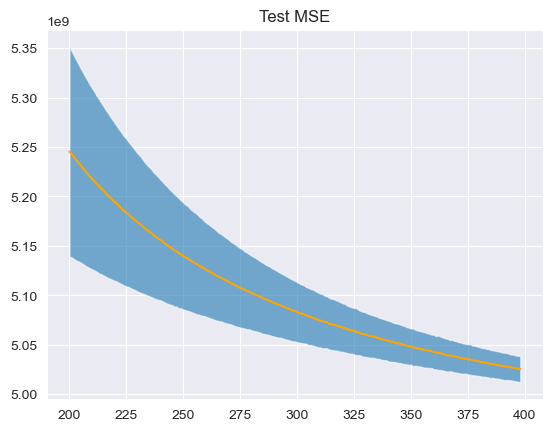

In [9]:
util.visualize_trains(
    f'../log/{model.name}(norm,{moving_avg.name},win={SLIDING_WIN},batch_size={BATCH_SIZE},valid_size={VALID_SIZE})', 
    9003,
    1,
    'Test MSE',
    start=200,
)


In [10]:
NUM_EPOCH = 400


# torch.autograd.set_detect_anomaly(True
assert False

@torch.no_grad()
def test(_test_loader) -> np.ndarray:
    # results = []
    for b, (X, y) in enumerate(_test_loader):
        O = X[:, :, 2:].unsqueeze(dim=-2)
        T = X[:, :, 1:2]
        T_next = T[:, -1:, :] + 1
        X = X[:, :, :1]
        y = y[:, :1]
        y_pred = model(X, e_t=None, e_s=None, T_next=T_next, other_vars=None).squeeze(dim=-2)
        
        batch_results = [metrics_fn(y, y_pred).item() for metrics_fn in metrics]
    
        if loss_fn is not None:
            loss = loss_fn(y_pred, y).item()
            batch_results = [loss] + batch_results
            
        return batch_results


for e in range(0, NUM_EPOCH):
    epoch_loss = []
    for b, (X, y) in enumerate(train_loader):
        O = X[:, :, 2:].unsqueeze(dim=-2)
        T = X[:, :, 1:2]
        T_next = T[:, -1:, :] + 1
        X = X[:, :, :1]
        
        y = y[:, :1]
        
        y_pred = model(X, e_t=None, e_s=None, T_next=T_next, other_vars=None).squeeze(dim=-2)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    epoch_valid_results = test(valid_loader)
    util.log_train(e, model, epoch_loss, epoch_valid_results, save_dir=SAVE_DIR)    

AssertionError: 

In [ ]:
_1 = util.visualize_train(
    os.path.join(SAVE_DIR, util.now.strftime('%Y-%m-%d-%H-%M')), 
    # os.path.join(SAVE_DIR, '2024-05-29-21-47'), 
    # os.path.join(SAVE_DIR, '2024-06-05-21-35'), 
    ['valid_loss', 'MAE'],
    v_lines = [50, 225]
)
# util.load_checkpoint(model, SAVE_DIR, '2024-06-05-21-35', epoch=225)

In [ ]:
# _ = util.visualize_train(
#     os.path.join(f'../log/DLinear(norm, win={10}, batch_size={BATCH_SIZE}, valid_size={20})/', '2024-05-29-21-47'), 
#     ['valid_loss', 'MAE'],
#     # v_lines = [50, 80]
# )

In [ ]:
_1['valid_loss'][200:].plot(figsize=(12, 6))

In [ ]:
_1['MAE'].plot(figsize=(12, 6))

In [ ]:
pred_train_list, y_train_list = [], []
for X, y in train_set:
    X, y = X.unsqueeze(dim=0), y.unsqueeze(dim=0)
    O = X[:, :, 2:].unsqueeze(dim=-2)
    T = X[:, :, 1:2]
    T_next = T[:, -1:, :] + 1
    X = X[:, :, :1]
    
    y = y[:, :1]
    
    y_pred = model(X, e_t=None, e_s=None, T_next=T_next, other_vars=None).squeeze(dim=-2)
    y_train_list.append(y.numpy().item())
    pred_train_list.append(y_pred.detach().numpy().item())

In [ ]:
pred_valid_list, y_valid_list = [], []
for X, y in valid_set:
    X, y = X.unsqueeze(dim=0), y.unsqueeze(dim=0)
    O = X[:, :, 2:].unsqueeze(dim=-2)
    T = X[:, :, 1:2]
    T_next = T[:, -1:, :] + 1
    X = X[:, :, :1]
    
    y = y[:, :1]
    
    y_pred = model(X, e_t=None, e_s=None, T_next=T_next, other_vars=None).squeeze(dim=-2)
    y_valid_list.append(y.numpy().item())
    pred_valid_list.append(y_pred.detach().numpy().item())

In [ ]:
series_id = 0
start = None
end = None
pd.Series(y_train_list)[start: end].plot(figsize=(12, 6), label='y_true')
pd.Series(pred_train_list)[start: end].plot(label='y_pred')
plt.legend()

In [ ]:
pd.Series(y_valid_list).plot(figsize=(12, 6), label='y_true')
pd.Series(pred_valid_list).plot(label='y_pred')
plt.legend()